<a href="https://colab.research.google.com/github/Mingrui-Wang/FYP/blob/master/%E2%80%9CSimple_LSTM_non_outlier_ipynb%E2%80%9D%E7%9A%84pratice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/FYP数据集/"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Line_100_day.csv', 'Line_100_day_winsorize.csv']

In [101]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

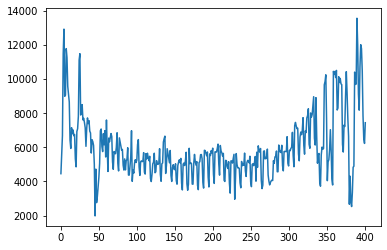

In [102]:
# load the dataset
dataframe = read_csv('Line_100_day_winsorize.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

In [103]:
# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

In [104]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [105]:
# use this function to prepare the train and test datasets for modeling
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [106]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [107]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.layers import LSTM
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
from keras import regularizers
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model.add(BatchNormalization())
model.add(LSTM(64, activation='relu',return_sequences=True))  # 返回维度为 64 的向量序列
model.add(LSTM(64,activation='tanh'))  # 返回维度为 64 的单个向量

model.add(Dense(1,activation='linear',kernel_regularizer=regularizers.l2(0.01)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=16)

Epoch 1/400
18/18 [==============================] - 0s 10ms/step - loss: 0.0980
Epoch 2/400
18/18 [==============================] - 0s 9ms/step - loss: 0.0406
Epoch 3/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 4/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0178
Epoch 5/400
18/18 [==============================] - 0s 9ms/step - loss: 0.0160
Epoch 6/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0144
Epoch 7/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0132
Epoch 8/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0121
Epoch 9/400
18/18 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 10/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 11/400
18/18 [==============================] - 0s 10ms/step - loss: 0.0104
Epoch 12/400
18/18 [==============================] - 0s 10ms/step - loss: 0.0092
Epoch 13/400
18/18 [==============

In [108]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [109]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [110]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 665.73 RMSE
Test Score: 1775.46 RMSE


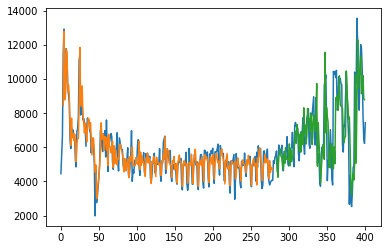

In [111]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [112]:
import numpy as np
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

trainScore = mape(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAPE' % (trainScore))
testScore = mape(testY[0], testPredict[:,0])
print('Test Score: %.2f MAPE' % (testScore))

Train Score: 0.09 MAPE
Test Score: 0.18 MAPE
